<a href="https://colab.research.google.com/github/IKEDAKAZUKI/Quantum-Energy-Teleportation/blob/main/Quantum_Energy_Teleportation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

We demonstrate Quantum Energy Teleportation with Real Quantum Computers.
More infortmation will be provided in my personal [website](https://kazukiikeda.studio.site/) and in the following references. 


---



The main reference for quantum energy teleportation using IBM's quantum computer is 

1. K. Ikeda, "First Realization of Quantum Energy Teleportation on Superconducting Quantum Hardware" [arXiv:2301.02666](https://arxiv.org/abs/2301.02666) (7 Jan 2023)

Quantum energy teleportation on a long-range and large-scale quantum networks is addressed in 
2. K. Ikeda, "Long-range quantum energy teleportation and distribution on a hyperbolic quantum network", [arXiv:2301.11884](https://arxiv.org/abs/2301.11884) (27 Jan 2023)

Physics implications of quantum energy teleportation are 
3. K. Ikeda, "Criticality of quantum energy teleportation at phase transition points in quantum field theory
" [arXiv:2301.11712
](https://arxiv.org/abs/2301.11712) (27 Jan 2023)

4. K. Ikeda, "Investigating global and topological order of states by local measurement and classical communication: Study on SPT phase diagrams by quantum energy teleportation" [arXiv:2302.09630](https://arxiv.org/abs/2302.09630) (19 Feb 2023)

# Install Qiskit and packages

If Qiskit is not installed, please install it.

In [18]:
pip install qiskit qiskit-ibmq-provider

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [12]:
import numpy as np 
from qiskit import * #qiskit
from qiskit.visualization import plot_histogram, plot_bloch_multivector, array_to_latex
from qiskit import Aer
from qiskit.extensions import Initialize
from qiskit import QuantumCircuit, QuantumRegister, transpile, execute
from qiskit.quantum_info import random_statevector
from qiskit.quantum_info import partial_trace, entropy
import qiskit.quantum_info as qi

We first get the simulator.

In [13]:
simulator = Aer.get_backend('qasm_simulator')

# Definition of the model

We use the Hamiltonian $H=H_A+H_B+V$, where $H_A,H_B,V$ are Alice's Hamiltonian, Bob's Hamiltonian and the interaction term between Alice and Bob. Their explicit forms are
\begin{align}
H_A&=kZ_0+\frac{h^2}{\sqrt{k^2+h^2}}\\
H_B&=kZ_1+\frac{h^2}{\sqrt{k^2+h^2}}\\
V&=2kX_0X_1+\frac{2k^2}{\sqrt{h^2+k^2}}
\end{align}

The ground state $|g\rangle$ of this Hamiltonian $H$ is 
\begin{equation}
|g\rangle=\frac{1}{\sqrt{2}}\sqrt{1-\frac{h}{\sqrt{h^2+k^2}}}|00\rangle-\frac{1}{\sqrt{2}}\sqrt{1+\frac{h}{\sqrt{h^2+k^2}}}|11\rangle.
\end{equation}

Note that the energy expectation value is fixed to 0 for each operator:
\begin{equation}
\langle g|H|g\rangle=\langle g|H_A|g\rangle=\langle g|H_B|g\rangle=\langle g|V|g\rangle=0. 
\end{equation}

It is important that while $|g\rangle$ is the ground state of $H$, it is not the ground state of $H_A,H_B,V$. In other words, Bob has a chance to decrese his local energy. How can he decrese his energy?

# Generate the ground state

Generating the ground state $|g\rangle$ of the Hamiltonian is possible by the following circuit:

In [ ]:

qr = QuantumRegister(2)
cr = ClassicalRegister(3)

qc = QuantumCircuit(qr, cr)

# Define the parameters
k=1
h=1.5

#Prepare the ground state
alpha=-np.arcsin((1/np.sqrt(2))*(np.sqrt(1+h/np.sqrt(h**2+k**2))))

qc.ry(2*alpha,qr[0])
qc.cx(qr[0],qr[1])

qc.draw()

┌─────────────┐     
q158_0: ┤ Ry(-2.5536) ├──■──
        └─────────────┘┌─┴─┐
q158_1: ───────────────┤ X ├
                       └───┘
 c31: 3/════════════════════

Compute the entanglement entropy of the ground state $S(|g\rangle\langle g|)$

In [ ]:
stv = qi.Statevector.from_instruction(qc)

sim = Aer.get_backend('aer_simulator_statevector')
options = {'method': 'statevector'}
execute(qc, sim, backend_options=options)

stv.draw('text', prefix='ground state:')

reduced_state = partial_trace(stv, [1])

print("Entanglement entropy is",entropy(reduced_state))

Entanglement entropy is 0.7219280948873625


# Step 1: Alice's operation to inject energy into the system

Alice can inject energy into the system by measuring her qubit. Since $|g\rangle$ is the ground state of the system, any operation to $|g\rangle$ excites the energy. This corresponds to the energy that is injected by Alice's measurement device. 

We use 
\begin{equation}
P_A(\mu)=\frac{1}{2}(1+\mu X_0),~\mu\in\{-1,1\}
\end{equation}
for Alice's projective measurement. When she measures her qubit with $P_A(\mu)$, she gets $\mu=+1$ or $-1$. Suppose Alice repeates the measurement. Then her local energy is statistically
\begin{equation}
E_A=\sum_{\mu\in\{0,1\}}\frac{1}{p_A(\mu)}\langle g|P_A(\mu)H_AP_A(\mu)|g\rangle. 
\end{equation}

It is important that Alice's operation commuts $[P_A( \mu), H_B+V]=0$ with $H_B$ and $V$, therefore Alice's measurement does not affect Bob's energy.

For the $X$ measurement, we convert the basis vectors from $|0\rangle,|1\rangle$ into $|\pm\rangle=\frac{|0\rangle\pm|1\rangle}{\sqrt{2}}$ using the Hadamard gate. The quantum circuit of Alice's measurement for the ground state $|g\rangle$ is expressed as follows:

In [ ]:
# Alice's projective measurement
qc.h(qr[0])
qc.measure(qr[0],cr[0])

qc.draw()

┌─────────────┐     ┌───┐┌─┐
q158_0: ┤ Ry(-2.5536) ├──■──┤ H ├┤M├
        └─────────────┘┌─┴─┐└───┘└╥┘
q158_1: ───────────────┤ X ├──────╫─
                       └───┘      ║ 
 c31: 3/══════════════════════════╩═
                                  0

# Step 2: Bob's conditional operations to get energy

As soon as Alice observes $\mu\in\{-1,+1\}$, she tells it to Bob. Then Bob operates $U_B(\mu)$ to his qubit and measures $H_B$ and $V$. Bob can compute the interaction term $V$ since he knows Alice's result $\mu$.

The explicite form of $U_B(\mu)$ is given as 
\begin{equation}
U_B(\mu)=R_Y(2\mu\phi),
\end{equation}
where $\phi$ obeys 
\begin{align}
    \cos(2\phi)&=\frac{h^2+2k^2}{\sqrt{(h^2+2k^2)^2+h^2k^2}}\\
    \sin(2\phi)&=\frac{hk}{\sqrt{(h^2+2k^2)^2+h^2k^2}}.
\end{align}

It is very important that Bob uses the same value $\mu$ as Alice, otherwise the protocol will not work.
For example, Bob can measure $V$ by the following circuit:

In [ ]:
def sin(k,h):
    return (h*k)/np.sqrt((h**2+2*k**2)**2+(h*k)**2)

phi=0.5*np.arcsin(sin(k,h))

qc.ry(2*phi,qr[1]).c_if(cr[0], 0)
qc.ry(-2*phi,qr[1]).c_if(cr[0], 1)

qc.h(qr[1])
qc.measure(qr[1],cr[2])

qc.draw()

┌─────────────┐     ┌───┐┌─┐                                       
q158_0: ┤ Ry(-2.5536) ├──■──┤ H ├┤M├───────────────────────────────────────
        └─────────────┘┌─┴─┐└───┘└╥┘┌─────────────┐┌──────────────┐┌───┐┌─┐
q158_1: ───────────────┤ X ├──────╫─┤ Ry(0.33929) ├┤ Ry(-0.33929) ├┤ H ├┤M├
                       └───┘      ║ └──────╥──────┘└──────╥───────┘└───┘└╥┘
                                  ║  ┌─────╨─────┐  ┌─────╨─────┐        ║ 
 c31: 3/══════════════════════════╩══╡ c31_0=0x0 ╞══╡ c31_0=0x1 ╞════════╩═
                                  0  └───────────┘  └───────────┘        2

After Alice and Bob repeate this process many times, Bob's energy expectation value becomes

---


\begin{align}
\langle E_B\rangle&=\sum_{\mu\in\{-1,1\}}\langle g|P_A(\mu)U^\dagger_B(\mu)(H_B+V)U_B(\mu)P_A(\mu)|g\rangle\\
    &=-\frac{1}{\sqrt{h^2+k^2}}[hk\sin(2\phi)-(h^2+2k^2)(1-\cos(2\phi))],
\end{align}
which is negative in general. 

Due to the energy conservation law, $-\langle E_B\rangle$ should be sent to Bob's device. This is how Bob can receive energy from Alice. 

#Free energy - guess the classical information

In [35]:
qr = QuantumRegister(1)
cr = ClassicalRegister(3)

qc = QuantumCircuit(qr, cr)

# Define the parameters
k=1
h=1.5

#Prepare the ground state
alpha=-np.arcsin((1/np.sqrt(2))*(np.sqrt(1+h/np.sqrt(h**2+k**2))))

qc.ry(2*alpha,qr[0])
qc.x(qr[0])

def sin(k,h):
    return (h*k)/np.sqrt((h**2+2*k**2)**2+(h*k)**2)

phi=0.5*np.arcsin(sin(k,h))

qc.ry(2*phi,qr[0]).c_if(cr[0], 0)
qc.ry(-2*phi,qr[0]).c_if(cr[0], 1)

qc.h(qr[0])
qc.measure(qr[0],cr[2])

qc.draw()

┌─────────────┐┌───┐┌─────────────┐┌──────────────┐┌───┐┌─┐
 q29: ┤ Ry(-2.5536) ├┤ X ├┤ Ry(0.33929) ├┤ Ry(-0.33929) ├┤ H ├┤M├
      └─────────────┘└───┘└──────╥──────┘└──────╥───────┘└───┘└╥┘
                            ┌────╨─────┐   ┌────╨─────┐        ║ 
c7: 3/══════════════════════╡ c7_0=0x0 ╞═══╡ c7_0=0x1 ╞════════╩═
                            └──────────┘   └──────────┘        2

In [39]:
qr = QuantumRegister(2)
cr = ClassicalRegister(2)

qc = QuantumCircuit(qr, cr)

# Define the parameters
k=1
h=1.5

#Prepare the ground state
alpha=-np.arcsin((1/np.sqrt(2))*(np.sqrt(1+h/np.sqrt(h**2+k**2))))

qc.ry(2*alpha,qr[0])
qc.x(qr[0])

def sin(k,h):
    return (h*k)/np.sqrt((h**2+2*k**2)**2+(h*k)**2)

phi=0.5*np.arcsin(sin(k,h))

qc.ry(2*phi,qr[0])

qc.h(qr[0])
qc.measure(qr[0],cr[0])


qc.ry(2*alpha,qr[1])
qc.x(qr[1])
qc.ry(-2*phi,qr[1])
qc.h(qr[1])
qc.measure(qr[1],cr[1])

qc.draw()

┌─────────────┐┌───┐┌─────────────┐ ┌───┐┌─┐   
q33_0: ┤ Ry(-2.5536) ├┤ X ├┤ Ry(0.33929) ├─┤ H ├┤M├───
       ├─────────────┤├───┤├─────────────┴┐├───┤└╥┘┌─┐
q33_1: ┤ Ry(-2.5536) ├┤ X ├┤ Ry(-0.33929) ├┤ H ├─╫─┤M├
       └─────────────┘└───┘└──────────────┘└───┘ ║ └╥┘
c11: 2/══════════════════════════════════════════╩══╩═
                                                 0  1

#Quantum Circuits for Quantum Energy Teleportation 

The complete quantum circuite of quantum energy teleportation is given below. The default circuit corresponds to the measurement of the interaction term $V$. For the measurement of $H_B$, comment out qc.h(qr[1]) at the end of the circuit. 

In [30]:
def sin(k,h):
    return (h*k)/np.sqrt((h**2+2*k**2)**2+(h*k)**2)

qr = QuantumRegister(2)
cr = ClassicalRegister(2)

qc = QuantumCircuit(qr, cr)

# Define the parameters
k=1
h=1.5


#Prepare the ground state
alpha=-np.arcsin((1/np.sqrt(2))*(np.sqrt(1+h/np.sqrt(h**2+k**2))))

qc.ry(2*alpha,qr[0])
qc.cx(qr[0],qr[1])

# Alice's projective measurement
qc.h(qr[0])

#Bob's conditional operation
phi=0.5*np.arcsin(sin(k,h))
qc.cry(-2*phi,qr[0],qr[1])

qc.x(qr[0])
qc.cry(2*phi,qr[0],qr[1])
qc.x(qr[0])


#Measurement of the interaction V
# Comment out qc.h(qr[1]) below for the measurement of Bob's Z term
qc.h(qr[1])
qc.measure(qr,cr)
qc.draw()


┌─────────────┐     ┌───┐                ┌───┐               ┌───┐┌─┐   
q17_0: ┤ Ry(-2.5536) ├──■──┤ H ├───────■────────┤ X ├───────■───────┤ X ├┤M├───
       └─────────────┘┌─┴─┐└───┘┌──────┴───────┐└───┘┌──────┴──────┐├───┤└╥┘┌─┐
q17_1: ───────────────┤ X ├─────┤ Ry(-0.33929) ├─────┤ Ry(0.33929) ├┤ H ├─╫─┤M├
                      └───┘     └──────────────┘     └─────────────┘└───┘ ║ └╥┘
 c6: 2/═══════════════════════════════════════════════════════════════════╩══╩═
                                                                          0  1

In this circuit, we used the equivalent gates for Bob's conditional operations. Any conditional operation can be implemented equivalently by postponing Alice's measurement.

Now let us execute the protocol.
If we do not comment out qc.h(qr[1]) in the circuit above, $\langle V\rangle$ will be obtained. 

In [ ]:
n_shots=100000

qc_meas = QuantumCircuit(qr,cr)
qc_meas.measure(qr,cr)
#add main circuit to measurement circuit to have total circuit
qc_total = qc.compose(qc_meas)  

job = execute(qc_total, backend=simulator, shots=n_shots)
result = job.result()
counts = result.get_counts(qc) 

Alice's local energy 1.2444454415067656 STD is 0.004743402600560067
Exact E_A 1.2480754415067656
Interacting energy V -0.4894796075495416 STD is 0.006324549298092314


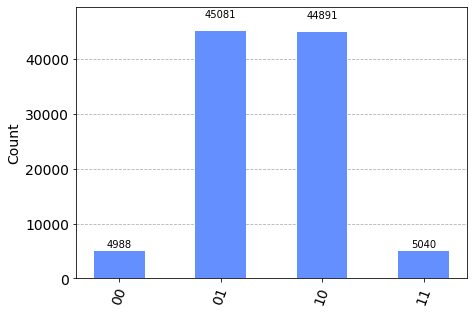

In [ ]:
ene_A=(h**2)/(np.sqrt(h**2+k**2))
#to compute the value of Bob's Z, comment out qc.h(qr[1]) in the circuit above and compute ene_B
#ene_B=(h**2)/(np.sqrt(h**2+k**2))
ene_V=(2*k**2)/(np.sqrt(h**2+k**2))
error_A=[]
error_B=[]
error_V=[]
for orig_bit_string, count in counts.items():
        bit_string = orig_bit_string[::-1]
        
        
        ene_A += h*(-1)**int(bit_string[0])*count/n_shots
        #ene_B += h*(-1)**int(bit_string[1])*count/n_shots
        ene_V += 2*k*(-1)**int(bit_string[0])*(-1)**int(bit_string[1])*count/n_shots
        
        
        
        for i in range(count):
            error_A.append(h*(-1)**int(bit_string[0]))
            #error_B.append(h*(-1)**int(bit_string[1]))
            error_V.append(2*k*(-1)**(int(bit_string[1])))
        


print("Alice's local energy",ene_A,"STD is",np.std(error_A)/np.sqrt(n_shots))
print("Exact E_A",h**2/np.sqrt(h**2+k**2))
#print("Bob's local energy",ene_B,"STD is",np.std(error_B)/np.sqrt(n_shots))

print("Interacting energy V",ene_V,"STD is",np.std(error_V)/np.sqrt(n_shots))



plot_histogram(counts) 

We found $\langle V\rangle$ negative as expected. ($\langle H_B\rangle$ is positive in general. )


# Quantum Energy Teleportation on a Real Quantum Computer

Experience quantum teleportation with a real quantum device. 
Create your IBM token for free [here](https://quantum-computing.ibm.com/). 
You'll have access to 7-qubit and 5-qubit quantum computers.  

In [40]:
# Enable your account on Qiskit, replace 'My_API_Token' with your newly generated token
IBMQ.save_account('API_KEY')
IBMQ.load_account()
# After loading credentials we query the backends
# IBMQ.backends()

configrc.store_credentials:WARNING:2023-05-01 20:16:58,995: Credentials already present. Set overwrite=True to overwrite.
ibmqfactory.load_account:WARNING:2023-05-01 20:16:59,227: Credentials are already in use. The existing account in the session will be replaced.


<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>

In [41]:
#IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q')

Get the least-busy IBM quantum computer.

In [42]:
from qiskit.providers.ibmq import least_busy

small_devices = provider.backends(filters=lambda x: x.configuration().n_qubits >= 0
                                   and not x.configuration().simulator)
backend=least_busy(small_devices)

print("Name", backend.name())
print("Status", backend.status())
print("Limit",backend.job_limit())
print("Remaining Jobs",backend.remaining_jobs_count())
print("Number of Active Jobs",backend.active_jobs())

Name ibmq_manila
Status <qiskit.providers.models.backendstatus.BackendStatus object at 0x7f7d0c192770>
Limit <qiskit.providers.ibmq.backendjoblimit.BackendJobLimit object at 0x7f7d0c0dedd0>
Remaining Jobs 5
Number of Active Jobs []


In [43]:
n_shots=2000
qc_total = transpile(qc, backend)

job = execute(qc_total, backend=backend, shots=n_shots)
job.status()

<JobStatus.QUEUED: 'job is queued'>

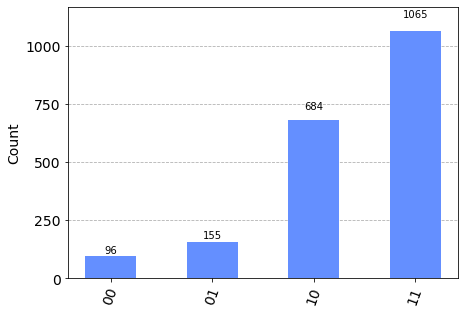

In [44]:
results = job.result()
counts = results.get_counts(qc_total) 
plot_histogram([counts])

Alice's local energy 1.2105754415067655 STD is 0.033530536455595214
Exact E_A 1.2480754415067656
Interacting energy V 0.23940039245045824 STD is 0.04471053567113684


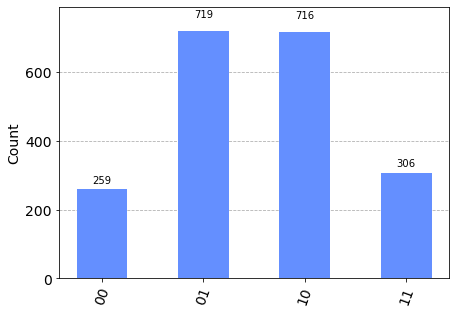

In [34]:
ene_A=(h**2)/(np.sqrt(h**2+k**2))
#to compute the value of Bob's Z, comment out qc.h(qr[1]) in the circuit above and compute ene_B
#ene_B=(h**2)/(np.sqrt(h**2+k**2))
ene_V=(2*k**2)/(np.sqrt(h**2+k**2))
error_A=[]
error_B=[]
error_V=[]
for orig_bit_string, count in counts.items():
        bit_string = orig_bit_string[::-1]
        
        
        ene_A += h*(-1)**int(bit_string[0])*count/n_shots
        #ene_B += h*(-1)**int(bit_string[1])*count/n_shots
        ene_V += 2*k*(-1)**int(bit_string[0])*(-1)**int(bit_string[1])*count/n_shots
        
        
        
        for i in range(count):
            error_A.append(h*(-1)**int(bit_string[0]))
            #error_B.append(h*(-1)**int(bit_string[1]))
            error_V.append(2*k*(-1)**(int(bit_string[1])))
        


print("Alice's local energy",ene_A,"STD is",np.std(error_A)/np.sqrt(n_shots))
print("Exact E_A",h**2/np.sqrt(h**2+k**2))
#print("Bob's local energy",ene_B,"STD is",np.std(error_B)/np.sqrt(n_shots))

print("Interacting energy V",ene_V,"STD is",np.std(error_V)/np.sqrt(n_shots))



plot_histogram(counts) 